In [3]:
import requests
import zipfile
import os
from PIL import Image
import io

Extracted!
Found 5249 images


## Get the image dataset (interiors of houses)

- Source: https://www.kaggle.com/datasets/mikhailma/house-rooms-streets-image-dataset/data
- Cached: https://max.io/house_data_png.zip (resized to 256x256 and converted to PNG)
- License: CC-0 Public Domain

In [ ]:
# Function to download and extract the zip file
def download_and_extract_zip(url, extract_to='.'):
    print('Downloading and extracting',url)
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        zip_ref.extractall(extract_to)

# Download and extract the example images
url = "https://max.io/house_data_png.zip"
download_and_extract_zip(url)
image_dir = 'house_data_png'
image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir)]
print('Extracted',len(image_paths),'images')

In [5]:
!pip install open_clip_torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 27.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 81.9 MB/s eta 0:00:00
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.6
    Uninstalling wcwidth-0.2.6:
      Successfully uninstalled wcwidth-0.2.6

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [8]:
from open_clip import tokenizer, create_model_and_transforms
import torch
from sklearn.neighbors import NearestNeighbors
import numpy as np
from tqdm import tqdm

model, transform, preprocess = create_model_and_transforms('ViT-B-32', pretrained='openai')

#Print the architecture, note both the "visual" and "transformer" branches of the model
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  

In [9]:
def get_image_embeddings(image_paths, batch_size=32):
    # Prepare the model and transformation
    embeddings = []

    # Process images in batches
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Processing Images"):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = [transform(Image.open(path)).unsqueeze(0) for path in batch_paths]

        # Stack and process the batch
        batch_images_tensor = torch.vstack(batch_images).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        
        with torch.no_grad():
            batch_embeddings = model.encode_image(batch_images_tensor)

        embeddings.append(batch_embeddings)

    # Concatenate all embeddings
    return torch.vstack(embeddings)

In [10]:
# Example usage with batch processing and progress bar
# Assuming you have a list of image file paths in 'image_paths'
image_embeddings = get_image_embeddings(image_paths, batch_size=32)

Processing Images: 100%|██████████| 165/165 [04:22<00:00,  1.59s/it]


In [40]:
image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True) #Normalization is required!

In [41]:
import pickle
with open('house_data_png.pkl', 'wb') as fd:
    pickle.dump(image_embeddings.cpu().numpy(), fd, pickle.HIGHEST_PROTOCOL)

In [42]:
print(len(image_embeddings),image_embeddings[0].shape)

5249 torch.Size([512])


In [43]:
#Encodes the text to the same vector space as the images!
def embed_text(text):
    tokens = tokenizer.tokenize([text])
    with torch.no_grad():
        text_features = model.encode_text(tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True) #Normalization is required!
    return text_features

In [74]:
from IPython.display import Image, display

# Function to display images
def display_images(image_paths,distances):
    for idx,path in enumerate(image_paths):
        display(Image(filename=path))
        print('👆',distances[idx])

In [75]:
def search(text,k=10):
    text_embedding = embed_text(text)
    nbrs = NearestNeighbors(n_neighbors=k, metric='cosine').fit(image_embeddings.cpu().numpy())
    distances, indices = nbrs.kneighbors(text_embedding.cpu().numpy())
    nearest_images = [image_paths[i] for i in indices[0]]
    display_images(nearest_images, distances[0])

[[0.6648878  0.6707206  0.67079556 0.67167574 0.6721866  0.6740758
  0.6742396  0.67437553 0.6755398  0.67583215]]


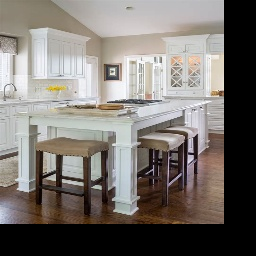

👆 0.6648878


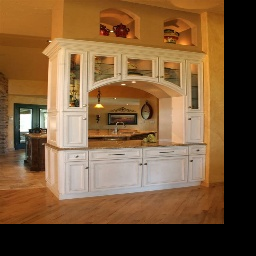

👆 0.6707206


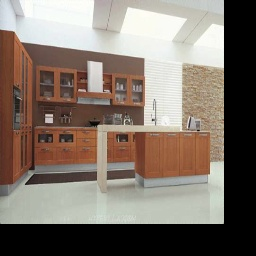

👆 0.67079556


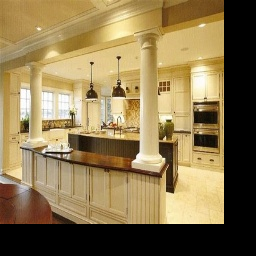

👆 0.67167574


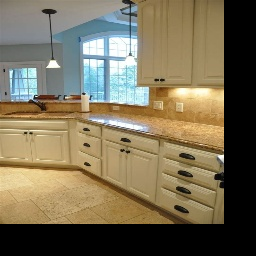

👆 0.6721866


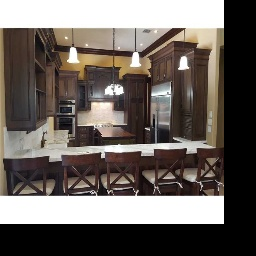

👆 0.6740758


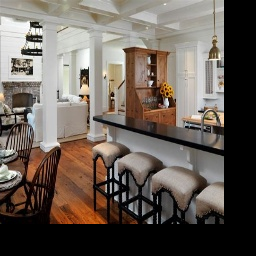

👆 0.6742396


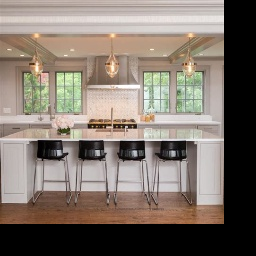

👆 0.67437553


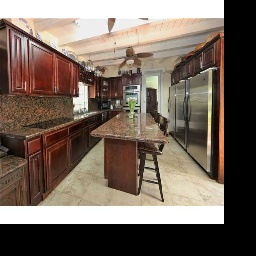

👆 0.6755398


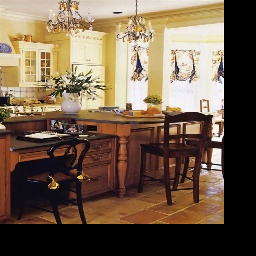

👆 0.67583215


In [76]:
search('large kitchen island colonial')